In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import shap


In [39]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(data.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [40]:
# Check for missing values
print(data.isnull().sum())

# Fill missing values (example: TotalCharges as numeric)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


C:\Users\Shubh\AppData\Local\Temp\ipykernel_24432\1161266661.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


In [41]:
# Encode categorical features
categorical_features = data.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_features:
    if col != 'customerID':  # Exclude unique identifier
        label_encoders[col] = LabelEncoder()
        data[col] = label_encoders[col].fit_transform(data[col])


In [42]:
# Drop irrelevant columns
data.drop(['customerID'], axis=1, inplace=True)

# Separate features and target variable
X = data.drop('Churn', axis=1)  # Features
y = data['Churn']  # Target


In [43]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [44]:
# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


In [45]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predictions
y_pred_logreg = logreg.predict(X_test)


In [46]:
# Train XGBoost classifier
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)


In [47]:
# Define a function for evaluation
def evaluate_model(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision: {precision_score(y_true, y_pred):.2f}")
    print(f"Recall: {recall_score(y_true, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_pred):.2f}")

# Evaluate logistic regression
print("Logistic Regression Performance:")
evaluate_model(y_test, y_pred_logreg)

# Evaluate XGBoost
print("\nXGBoost Performance:")
evaluate_model(y_test, y_pred_xgb)


Logistic Regression Performance:
Accuracy: 0.80
Precision: 0.64
Recall: 0.55
F1 Score: 0.59
ROC AUC: 0.72

XGBoost Performance:
Accuracy: 0.78
Precision: 0.60
Recall: 0.52
F1 Score: 0.56
ROC AUC: 0.70


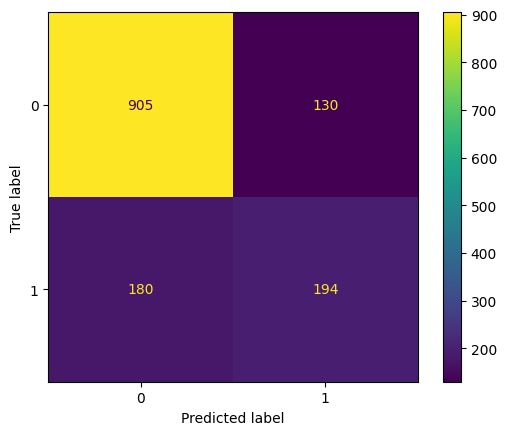

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix for XGBoost
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb)
plt.show()


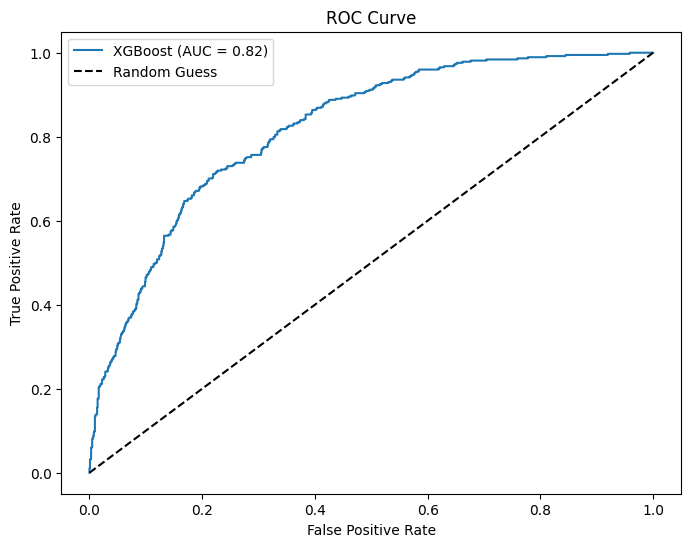

In [49]:
# Plot ROC curve
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]  # Probabilities for class 1
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_xgb)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


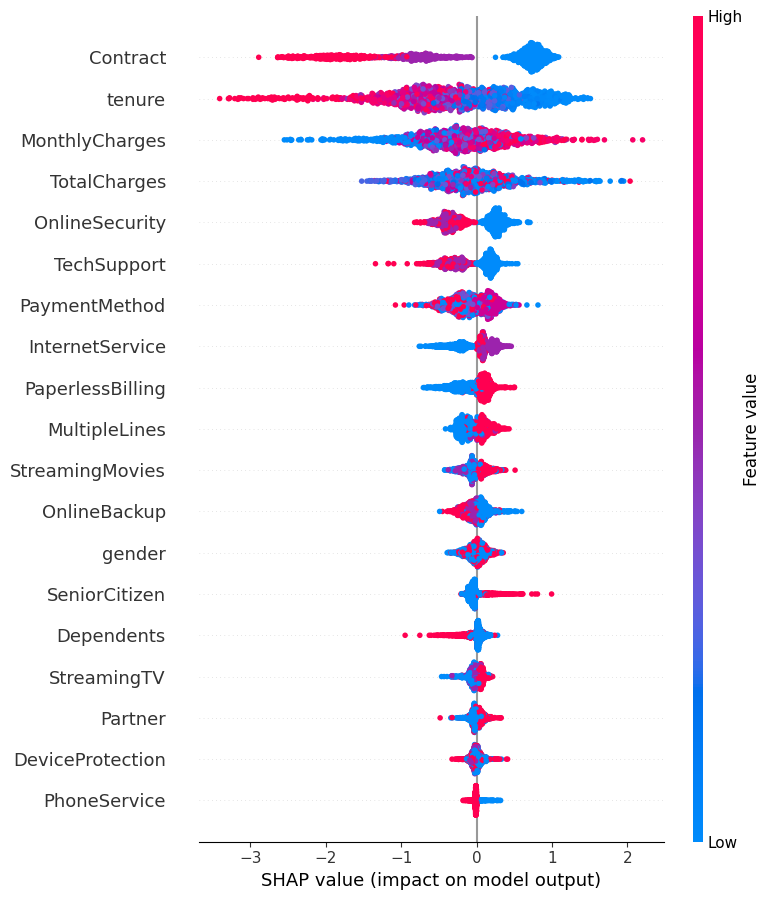

In [50]:
# Compute SHAP values
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
